In [3]:
#Here info:
#App ID: gB5Th31Aa7kCMDRB2yYH
#App Code: _V3OMdtHzj0vDll0eT6JsA

from sklearn.ensemble import RandomForestClassifier
from sklearn import (metrics, model_selection, linear_model, preprocessing, ensemble, neighbors, tree)
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pydotplus
import seaborn as sns
import numpy as np
import pandas as pd
import pprint as pp
import re
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier,plot_tree,to_graphviz
from IPython.display import Image 

%matplotlib inline

# markdown syntax:
# https://daringfireball.net/projects/markdown/syntax#header

In [4]:
import txdot_parse as txpars
import helpers

Introduction
===

Data Preprocessing
===

In [24]:
# import the "crash" data
data = pd.read_csv("my_map_grid.csv",header=10)

In [25]:
# preprocessing
# lowercase: http://stackoverflow.com/a/38931854
data.columns = data.columns.str.lower()
# remove spaces
data.columns = data.columns.str.replace(' ', '_')
# special cases
data.columns = data.columns.str.replace('crash_i_d', 'crash_id')
# remove whateva data

# replace ['No Data','Not Applicable'] with NaN
data.replace(to_replace='No Data', value=np.nan, inplace=True)
data.replace(to_replace='Not Applicable', value=np.nan, inplace=True)
data.latitude = pd.to_numeric(data.latitude)
data.longitude = pd.to_numeric(data.longitude)

In [26]:
data.speed_limit.replace(0,np.nan,inplace=True)
data.speed_limit.replace(-1,np.nan,inplace=True)
# impute speed limits
print("########################################")
verbose=0
if(verbose):
    print(data.speed_limit.value_counts())
totalmissing   = data[data['speed_limit'].isnull()].shape[0]
missingpercent = totalmissing / data.shape[0]
print("pre : total missing speed limit data:\n %s (%s of 1)" % (totalmissing, missingpercent))
if(verbose):
    print(data.speed_limit.unique())
data = txpars.impute_mph(data, verbose=0)
totalmissing   = data[data['speed_limit'].isnull()].shape[0]
missingpercent = totalmissing / data.shape[0]
print("post: total missing speed limit data:\n %s (%s of 1)" % (totalmissing, missingpercent))
if(verbose):
    print(data.speed_limit.unique())
    print(data.speed_limit.value_counts())
    print(data.info())
print("########################################")

########################################
pre : total missing speed limit data:
 575 (0.2576164874551971 of 1)
post: total missing speed limit data:
 458 (0.20519713261648745 of 1)
########################################


DecisionTree
===

In [11]:
# Use DecisionTreeClassifier with a limited number of features and visualize
# the the resulting tree

# https://research.vahula.com/scikit-learns-decision-tree-classifier-698ddbb05b
# http://scikit-learn.org/stable/modules/tree.html





# Let's select a small number of important features
# smalldf = data[['crash_severity',
#                 'crash_time', 
#                 'day_of_week', 
#                 'intersection_related', 
#                 'light_condition', 
#                 'manner_of_collision',
#                 'speed_limit',
#                 'surface_condition', 
#                 'weather_condition']]

# smalldf.head()

# dummies_needed_list = [
#  'day_of_week',
#  'intersection_related',
#  'light_condition',
#  'manner_of_collision',
#  'surface_condition',
#  'weather_condition']

smalldf = data[['crash_severity', 
                'intersection_related', 
                'light_condition', 
                'manner_of_collision',
                'surface_condition', 
                'weather_condition']]

smalldf.head()

dummies_needed_list = [
 'intersection_related',
 'light_condition',
 'manner_of_collision',
 'surface_condition',
 'weather_condition']

# encode data for dummies_needed_list
for feat in dummies_needed_list:
    smalldf = pd.concat([smalldf,pd.get_dummies(smalldf[feat],prefix=feat)],axis=1)
    smalldf = smalldf.drop([feat],axis=1)
    
smalldf.head()
X = smalldf.drop(['crash_severity'], axis=1)
y = smalldf['crash_severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

tree_classifier = tree.DecisionTreeClassifier()
tree_classifier.fit(X_train, y_train)

train_accuracy = tree_classifier.score(X_train, y_train)
test_accuracy = tree_classifier.score(X_test, y_test)
print('Tree train accuracy: ', train_accuracy)
print('Tree test accuracy: ', test_accuracy)

# graphviz needs to be installed
# on mac: brew install graphviz
# http://stackoverflow.com/questions/18438997/why-is-pydot-unable-to-find-graphvizs-executables-in-windows-8

# The feature_names and class_names oprtional parameters should be set so that the tree
# can have the actual names of features and classes
# http://scikit-learn.org/stable/modules/tree.html#classification
dot_data = tree.export_graphviz(tree_classifier, out_file=None, 
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

#print(tree_classifier.feature_importances_)


KeyError: "['intersection_related' 'light_condition' 'manner_of_collision'\n 'surface_condition' 'weather_condition'] not in index"

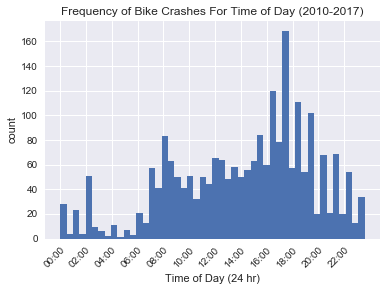

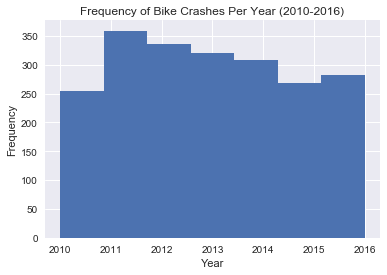

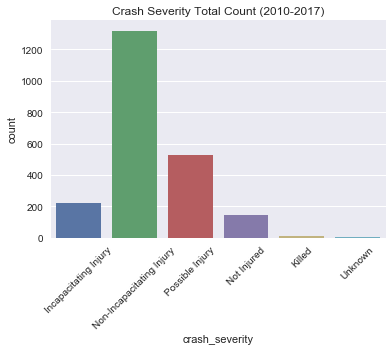

In [28]:
# Let's see the realationship between crashes and time of day
# First, let's just look at the total crashes vs time of day (no crash severity)

data = pd.read_csv("my_map_grid.csv",header=10)
data.columns = data.columns.str.lower()
# remove spaces
data.columns = data.columns.str.replace(' ', '_')

# add 
ax_time = helpers.get_ax_time(
        interval = '24h',
        title = 'Frequency of Bike Crashes For Time of Day (2010-2017)',
        xlabel = 'Time of Day (24 hr)',
        ylabel = 'count',
        )

data.crash_time.hist(bins=48,ax=ax_time)
plt.show()

# Let's see if there is a trend of total bike crashes by year
# We'll ignore 2017 data since it is incomplete
data.crash_year[data.crash_year != 2017].plot.hist(bins=7)
plt.xlabel('Year')
plt.title('Frequency of Bike Crashes Per Year (2010-2016)')
plt.show()

# Spread of Crash Severity data from 2010-2017
# Using seaborn for ease of use with categorical data
sns.countplot(x="crash_severity", data=data);
plt.xticks(rotation=45)
plt.title('Crash Severity Total Count (2010-2017)')
plt.show()


XGB Model
====

In [5]:
# import the "crash" data
data = pd.read_csv("my_map_grid.csv",header=10)

# preprocessing
# lowercase: http://stackoverflow.com/a/38931854
data.columns = data.columns.str.lower()
# remove spaces
data.columns = data.columns.str.replace(' ', '_')
# special cases
data.columns = data.columns.str.replace('crash_i_d', 'crash_id')
# remove whateva data

# replace ['No Data','Not Applicable'] with NaN
data.replace(to_replace='No Data', value=np.nan, inplace=True)
data.replace(to_replace='Not Applicable', value=np.nan, inplace=True)
data.latitude = pd.to_numeric(data.latitude)
data.longitude = pd.to_numeric(data.longitude)


dummies_needed_list = [
 'day_of_week',
 'intersection_related',
 'light_condition',
 'manner_of_collision',
 'road_base_type',
 'surface_condition',
 'weather_condition'
        ]

# encode data for dummies_needed_list
for feat in dummies_needed_list:
    data = pd.concat([data,pd.get_dummies(data[feat],prefix=feat)],axis=1)
    data = data.drop([feat],axis=1)

#remove data that will not be usefull
drop_columns = ['crash_id',
                'average_daily_traffic_amount',
                'average_daily_traffic_year',
                'street_name',
                'intersecting_street_name',
                'medical_advisory_flag',
                'object_struck',
               'crash_death_count',
               'crash_incapacitating_injury_count',
                'crash_non-incapacitating_injury_count',
               'crash_not_injured_count',
               'crash_possible_injury_count']
crash_id = data.crash_id
data = data.drop(drop_columns,axis=1)

#fix time column
data['100th_time']=data.crash_time/100
data['minutes'] = (data['100th_time']-data['100th_time'].apply(np.floor))*100
data['100th_time'] = (data['100th_time'].apply(np.floor))*60
data.crash_time = data.minutes+data['100th_time']
data.drop(['minutes'],axis=1,inplace=True)
data.drop(['100th_time'],axis=1,inplace=True)

#fill missing values
data = data.fillna(data.mean())

#split data into train/test,x/y
np.random.seed(0)

# The minimum number of groups for any class cannot be less than n_splits=5
# crash_severity == 'Unknown' has only 4 samples
train, test = train_test_split(data[data['crash_severity'] != 'Unknown'])
x_train = train.drop(['crash_severity'],axis=1)
y_train = train.crash_severity
x_test = test.drop(['crash_severity'],axis=1)
y_test = test.crash_severity


In [6]:
#cross validation function
def accuracy_cv(model):
    np.random.seed(0)
    accuracy = cross_val_score(model,x_train,y_train.as_matrix().ravel(),scoring='accuracy',cv=5)
    return (accuracy)

max_depths = np.linspace(1,10,10,dtype=int)

#cross validation for max_depth parameter
cv_xgb = [accuracy_cv(XGBClassifier(max_depth=max_depth)).mean()
          for max_depth in max_depths]


KeyboardInterrupt: 

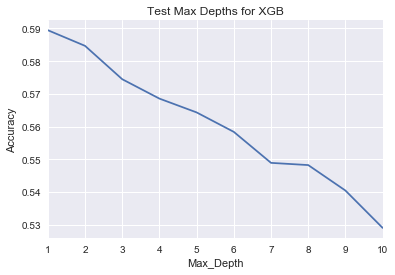

In [31]:
#plot results
cv_xgb = pd.Series(cv_xgb, index = max_depths)
cv_xgb.plot(title = "Test Max Depths for XGB")
plt.xlabel("Max_Depth")
plt.ylabel("Accuracy")
best_max_depth = cv_xgb.idxmax()

In [32]:
#cross validation for n_estimators
nestimators = np.linspace(91,110,dtype=int)
cv_xgb = [accuracy_cv(XGBClassifier(max_depth=best_max_depth,n_estimators=nestimator)).mean()
          for nestimator in nestimators]


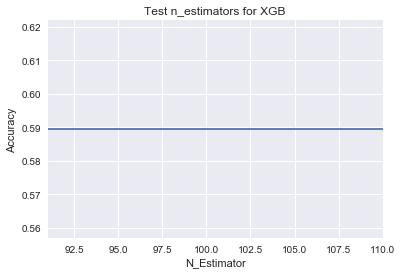

In [33]:
#plot results
cv_xgb = pd.Series(cv_xgb, index = nestimators)
cv_xgb.plot(title = "Test n_estimators for XGB")
plt.xlabel("N_Estimator")
plt.ylabel("Accuracy")
best_n_estimators = cv_xgb.idxmax()

In [34]:
#cross validation for colsample_bytree
colsample_bytree = np.linspace(.5,1)
cv_xgb = [accuracy_cv(XGBClassifier(max_depth=best_max_depth,n_estimators=best_n_estimators,colsample_bytree=i)).mean()
          for i in colsample_bytree]


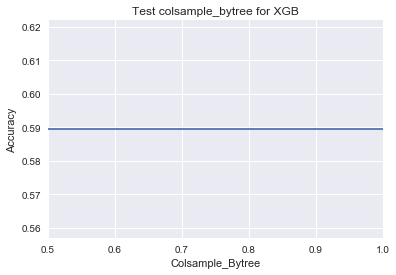

In [35]:
#plot results
cv_xgb = pd.Series(cv_xgb, index = colsample_bytree)
cv_xgb.plot(title = "Test colsample_bytree for XGB")
plt.xlabel("Colsample_Bytree")
plt.ylabel("Accuracy")
best_colsample_bytree = cv_xgb.idxmax()

XGB Train accuracy: 0.588868940754
XGB Test accuracy: 0.603231597846
crash_time : 0.241758
longitude : 0.175824
latitude : 0.164835
speed_limit : 0.0835165
intersection_related_Non Intersection : 0.0769231
crash_year : 0.043956
road_base_type_Flex Base (Granular) : 0.0373626
day_of_week_Saturday : 0.032967
day_of_week_Friday : 0.0307692
light_condition_Dark, Lighted : 0.0285714
manner_of_collision_One Motor Vehicle - Turning Right : 0.0241758
light_condition_Dusk : 0.021978
intersection_related_Driveway Access : 0.021978
light_condition_Dark, Unknown Lighting : 0.00879121
day_of_week_Wednesday : 0.0021978
light_condition_Dark, Not Lighted : 0.0021978
light_condition_Dawn : 0.0021978


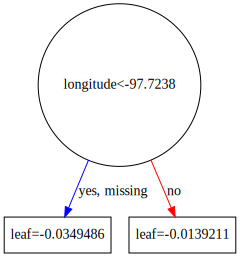

In [36]:
#train xgb model and check performance
model_xgb = XGBClassifier(max_depth=1,colsample_bytree=best_colsample_bytree,n_estimators=best_n_estimators)
model_xgb.fit(x_train,y_train)
print("XGB Train accuracy:", model_xgb.score(x_train,y_train))
print("XGB Test accuracy:",model_xgb.score(x_test,y_test))

#print important features list and their overall importance in the xgb model
columns = []
feature_importances = []
for i in range(0,len(model_xgb.feature_importances_)):
    if model_xgb.feature_importances_[i]!=0:
        columns.append(x_train.columns[i])
        feature_importances.append(model_xgb.feature_importances_[i])
        
sorted_index = np.argsort(feature_importances)[::-1]
for i in sorted_index:
    print(columns[i],":",feature_importances[i])

to_graphviz(model_xgb)

0.241758 : crash_time
0.175824 : longitude
0.164835 : latitude
0.083516 : speed_limit
0.076923 : intersection_related_Non Intersection
0.043956 : crash_year
0.037363 : road_base_type_Flex Base (Granular)
0.032967 : day_of_week_Saturday
0.030769 : day_of_week_Friday
0.028571 : light_condition_Dark, Lighted
0.024176 : manner_of_collision_One Motor Vehicle - Turning Right
0.021978 : intersection_related_Driveway Access
0.021978 : light_condition_Dusk
0.008791 : light_condition_Dark, Unknown Lighting
0.002198 : day_of_week_Wednesday
0.002198 : light_condition_Dark, Not Lighted
0.002198 : light_condition_Dawn


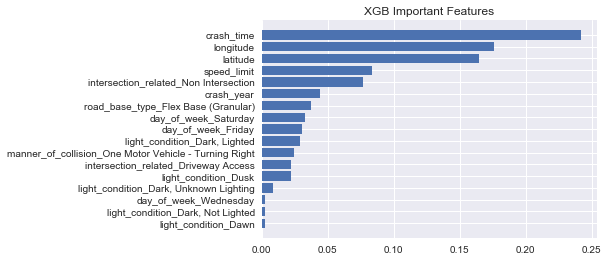

In [38]:
# print important features
xgb_imp_feats = helpers.print_model_feats_important(model_xgb, x_train.columns)
ax = helpers.get_ax_barh(xgb_imp_feats, title="XGB Important Features")
plt.show()

In [9]:
#train test difference cross validation function
def train_test_accuracy_cv(model):
    np.random.seed(0)
    train_accuracy = cross_val_score(model,x_train,y_train.as_matrix().ravel(),scoring='accuracy',cv=5).mean()
    model.fit(x_train,y_train.as_matrix().ravel())
    test_accuracy = model.score(x_test,y_test.as_matrix().ravel())
    return (np.abs(train_accuracy-test_accuracy))

Random Forest
===

In [10]:
#random forest
#train with limited number of features ,log2 works the best of the parameter options
np.random.seed(0)

#cross validate the max depth 
max_depths = np.linspace(1,10,10,dtype=int)
cv_max_depth = [train_test_accuracy_cv(RandomForestClassifier(max_features='log2',max_depth=max_depth))
          for max_depth in max_depths]

print("cv_max_depth",cv_max_depth)
best_max_depth = cv_max_depth.index(min(cv_max_depth))+1

#cross validate the minimum number of leaves to minimize the difference in train/test error
min_leaves = np.linspace(1,50,50,dtype=int)
cv_randForest = [train_test_accuracy_cv(RandomForestClassifier(max_features='log2',
                                                               min_samples_leaf=min_leaf,
                                                              max_depth=best_max_depth)).mean()
          for min_leaf in min_leaves]

#retrain based on cross validation results
best_min_leaves = cv_randForest.index(min(cv_randForest))+1

randForest = RandomForestClassifier(max_features='log2',min_samples_leaf=best_min_leaves,max_depth=best_max_depth)
randForest.fit(x_train,y_train)

print("cv_randForest",max(cv_randForest))

#view performance of random forest
print("Random Forest Train accuracy:", randForest.score(x_train,y_train))
print("Random Forest Test accuracy:",randForest.score(x_test,y_test),"\n")
columns = []
feature_importances = []

#view importance features
for i in range(0,len(randForest.feature_importances_)):
    if randForest.feature_importances_[i]!=0:
        columns.append(x_train.columns[i])
        feature_importances.append(randForest.feature_importances_[i])
        
#sort importance features by importance
sorted_index = np.argsort(feature_importances)[::-1]
for i in sorted_index:
    print(columns[i],":",feature_importances[i])
    
randForest.get_params

cv_max_depth [0.014351031628324629, 0.014351031628324629, 0.014351031628324629, 0.014949834023534225, 0.016151046057298113, 0.019147579394944492, 0.014947301732365026, 0.011965964991085487, 0.0053671882837978968, 0.021533942284459706]
cv_randForest 0.0173457883287
Random Forest Train accuracy: 0.658886894075
Random Forest Test accuracy: 0.594254937163 

latitude : 0.128413378878
crash_time : 0.124511950546
longitude : 0.110815806635
speed_limit : 0.0869589059126
crash_year : 0.0825554111415
intersection_related_Non Intersection : 0.0304538797711
intersection_related_Intersection : 0.024411678613
road_base_type_Flex Base (Granular) : 0.0239622990189
manner_of_collision_One Motor Vehicle - Going Straight : 0.0233207114847
light_condition_Daylight : 0.0229438118151
day_of_week_Thursday : 0.0221939736055
light_condition_Dark, Lighted : 0.0207958360554
manner_of_collision_One Motor Vehicle - Turning Left : 0.0207557366651
intersection_related_Intersection Related : 0.0202811845379
day_of_we

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)>

In [41]:
# KNN
# https://kevinzakka.github.io/2016/07/13/k-nearest-neighbor/

# creating odd list of K for KNN
myList = list(range(1,50))

# subsetting just the odd ones
neighbors = filter(lambda x: x % 2 != 0, myList)

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

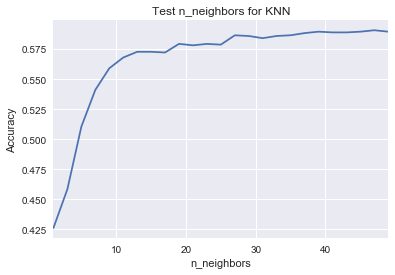

The optimal number of neighbors is 47
This has an accuracy of:  0.590676984138


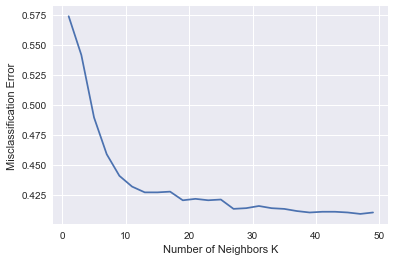

KNN Train accuracy: 0.588270496709
KNN Test accuracy: 0.603231597846


In [42]:
# plot results for KNN n_neighbors 
neighbors_list = list(filter(lambda x: x % 2 != 0, myList))
cv_knn = pd.Series(cv_scores, index=neighbors_list)
cv_knn.plot(title = "Test n_neighbors for KNN")
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy")
plt.show()

# We can also show show this as misclassification error, and
# take the minimum.

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors_list[MSE.index(min(MSE))]
print ("The optimal number of neighbors is %d" % optimal_k)
print ("This has an accuracy of: ", cv_scores[MSE.index(min(MSE))])

# plot misclassification error vs k
plt.plot(neighbors_list, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

knn_model = KNeighborsClassifier(n_neighbors=optimal_k) # k = 29
knn_model.fit(x_train, y_train)

print("KNN Train accuracy:", knn_model.score(x_train,y_train))
print("KNN Test accuracy:", knn_model.score(x_test,y_test))

Decision Tree
===

Human-Readable Model
---

The complex model is good for making route predictions.

But what about getting an intuitive feel?

Decision Trees are good for creating explainable models.